# Clustering Stock Returns: Comparing PCA + K-means and DTW + K-means

This study highlights that applying Dynamic Time Warping (DTW) compared to Principal Component Analysis (PCA) before K-means clustering can provide more economic insights. DTW excels in capturing temporal shifting information when calculating distances, effectively addressing the lead-lag effects common in stock markets. For instance, within sectors, large-cap stocks often lead small-cap stocks due to their quicker reactions to market news and economic changes. This is a result of their higher liquidity, better access to information, and extensive analyst coverage. Additionally, lead-lag effects are prevalent across supply chains.

Traditional methods, such as using PCA followed by K-means clustering, fail to capture these temporal nuances. In contrast, clustering methods based on distance metrics like DTW can take these relationships into account.

When conducting K-means clustering, we typically examine the inertia-number of clusters graph to determine the optimal number of clusters. However, for convenience, I selected 10 clusters for this study. Data was gathered through web scraping methods to include the S&P 500 component stocks. While the most formal approach involves using CRSP data and the S&P component historical list, for demonstration purposes, I combined web scraping with the Yahoo Finance API.

This approach underscores the importance of considering temporal relationships in clustering analysis, providing a more comprehensive representation of market dynamics in complement to traditional PCA methods.

The study utilizes data spanning from January 1, 2022, to December 31, 2022.

# Outline:
- K-means Clustering with Normalized Stock Returns
- K-means Clustering with PCA on Normalized Stock Returns
- K-means Clustering with Dynamic Time Warping (DTW) on Stock Returns

Suppose we have the following companies in mind and want to analyze how they are related to each other.

In [1]:
companies_dict = {
    'Amazon':'AMZN',
    'Apple':'AAPL',
    'American Express':'AXP',
    'Boeing':'BA',
    'Bank of America':'BAC',
    'Chevron':'CVX',
    'Costco':'COST',
    'Exxon':'XOM',
    'Ford':'F',
    'General Electrics':'GE',
    'Honda':'HMC',
    'IBM':'IBM',
    'Lockheed Martin':'LMT',
    'Intel':'INTC',
    'Jpmorgan Chase':'JPM',
    'MasterCard':'MA',
    'Microsoft':'MSFT',
    'NVIDIA':'NVDA',
    'Northrop Grumman':'NOC',
    'Toyota':'TM',
    'Texas Instruments':'TXN',
    'Valero Energy':'VLO',
    'Visa':'V',
    'Walmart':'WMT'
    }

# Import Packages, Scrape Data, and Clean Data

In [2]:
!pip install yfinance &> /dev/null
!pip install tslearn &> /dev/null

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [4]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import plotly.graph_objects as go
import bs4 as bs
import requests

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import defaultdict

In [5]:
# Scrap sp500 tickers
def save_sp500_tickers():

    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'html')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        if not '.' in ticker:
            tickers.append(ticker.replace('\n',''))

    return tickers

tickers = save_sp500_tickers()

In [6]:
prices = yf.download(tickers, start='2022-01-01',end='2022-12-31')['Adj Close']

[*********************100%%**********************]  501 of 501 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['GEV', 'VLTO', 'KVUE', 'SOLV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1641013200, endDate = 1672462800")


In [7]:
# Calculate stock return by using log difference, then droping the data on the first date.
return_stocks = prices.apply(np.log).diff(1).iloc[1:]#.fillna(0)
return_stocks = return_stocks.T
return_stocks.dropna(inplace = True, axis=0) # drop any stock with missing values, in this study, I don't want to introduce any noises in the analysis

In [8]:
# Define a Normalizer
normalizer = Normalizer() # this normalizer from sklearn will make the L2 norm for returns from each stock equal to 1. This way can help us conduct PCA
# Fit and transform
norm_returns = normalizer.fit_transform(return_stocks.values)

In [9]:
norm_returns

array([[-0.09814432, -0.04931111,  0.00996828, ..., -0.02799744,
         0.05723406, -0.0230764 ],
       [ 0.025512  , -0.03218615, -0.01053876, ..., -0.03015941,
         0.05420625,  0.00280792],
       [-0.03602013, -0.07602968, -0.04747454, ..., -0.08789074,
         0.07876711,  0.00695401],
       ...,
       [ 0.03324783, -0.01087654, -0.02747705, ..., -0.033555  ,
         0.04775802, -0.00851462],
       [ 0.01343001, -0.10920885, -0.01153464, ..., -0.03553327,
         0.09013943, -0.00926671],
       [-0.12114549, -0.12099029,  0.01236927, ..., -0.03173634,
         0.0923616 , -0.03389025]])

# K-means Clustering with Normalized Stock Returns

In [10]:
# Define the number of clusters
n_clusters = 10

# Create Kmeans model
kmeans = KMeans(n_init = 10, n_clusters = n_clusters,max_iter = 1000)
# Make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer,kmeans)
# Fit pipeline to daily stock movements
pipeline.fit(return_stocks.values)
# Prediction
labels = pipeline.predict(return_stocks.values)

stock_clusters_pca = defaultdict(list)
for index in range(len(labels)):
    stock_clusters_pca[labels[index]].append(return_stocks.index[index])

for i in range(n_clusters):
    print(f"Cluster {i} contains {len(stock_clusters_pca[i])} stocks")
    print(stock_clusters_pca[i],"\n")
print(kmeans.inertia_)

Cluster 0 contains 27 stocks
['ADM', 'APA', 'BG', 'BKR', 'CF', 'COP', 'CTRA', 'CTVA', 'CVX', 'DVN', 'EOG', 'EQT', 'FANG', 'HAL', 'HES', 'KMI', 'MOS', 'MPC', 'MRO', 'OKE', 'OXY', 'PSX', 'SLB', 'TRGP', 'VLO', 'WMB', 'XOM'] 

Cluster 1 contains 53 stocks
['ABBV', 'ACGL', 'AIZ', 'ALL', 'AMGN', 'AZO', 'BAX', 'BDX', 'BIIB', 'BMY', 'CAH', 'CB', 'CBOE', 'CHTR', 'CI', 'CINF', 'CMCSA', 'CME', 'CNC', 'COR', 'CVS', 'DVA', 'EG', 'ELV', 'GEN', 'GILD', 'HCA', 'HSIC', 'HUM', 'IBM', 'INCY', 'LLY', 'MCD', 'MCK', 'MDT', 'MOH', 'MRK', 'NEM', 'ORLY', 'PFE', 'PGR', 'REGN', 'RTX', 'STZ', 'T', 'TMUS', 'TRV', 'UHS', 'UNH', 'VRTX', 'VZ', 'WBA', 'WRB'] 

Cluster 2 contains 26 stocks
['AMT', 'ARE', 'AVB', 'BXP', 'CCI', 'CPT', 'DLR', 'DOC', 'EQIX', 'EQR', 'ESS', 'EXR', 'FRT', 'INVH', 'IRM', 'KIM', 'MAA', 'O', 'PLD', 'PSA', 'REG', 'SBAC', 'UDR', 'VICI', 'VTR', 'WELL'] 

Cluster 3 contains 87 stocks
['ADP', 'AES', 'AJG', 'AKAM', 'ALLE', 'AMCR', 'AME', 'AON', 'AOS', 'APD', 'BALL', 'BBY', 'BLDR', 'BLK', 'BR', 'BRO', '

In [11]:
companies_clusters = defaultdict(list)

for k,v in companies_dict.items():
    for j in stock_clusters_pca:
        if v in stock_clusters_pca[j]:
            companies_clusters[j].append(k)

companies_clusters

defaultdict(list,
            {7: ['Amazon'],
             8: ['Apple',
              'Intel',
              'MasterCard',
              'Microsoft',
              'NVIDIA',
              'Texas Instruments',
              'Visa'],
             5: ['American Express',
              'Boeing',
              'Bank of America',
              'Ford',
              'General Electrics',
              'Jpmorgan Chase'],
             0: ['Chevron', 'Exxon', 'Valero Energy'],
             3: ['Costco'],
             1: ['IBM'],
             4: ['Lockheed Martin', 'Northrop Grumman'],
             6: ['Walmart']})

Remember: These clusters is only based on the daily stock returns.

# K-means Clustering with PCA on Normalized Stock Returns

In [12]:
# Reduce the data
reduce_data = PCA(n_components = 2)

# Create Kmeans model
kmeans = KMeans(n_init = 10,n_clusters = 10,max_iter = 1000)
# Make a pipeline chaining normalizer, pca and kmeans
pipeline = make_pipeline(normalizer,reduce_data,kmeans)
# Fit pipeline to daily stock movements
pipeline.fit(return_stocks.values)
# Prediction
labels = pipeline.predict(return_stocks.values)

stock_clusters_pca = defaultdict(list)
for index in range(len(labels)):
    stock_clusters_pca[labels[index]].append(return_stocks.index[index])

print(stock_clusters_pca)

defaultdict(<class 'list'>, {5: ['A', 'ABT', 'ADP', 'AJG', 'AKAM', 'ALLE', 'AME', 'AON', 'ARE', 'BIO', 'BR', 'BRO', 'COO', 'COST', 'CTAS', 'CTLT', 'DHR', 'DLR', 'DPZ', 'ECL', 'EQIX', 'EW', 'FAST', 'FDS', 'FICO', 'HD', 'HOLX', 'ICE', 'IEX', 'IQV', 'LH', 'LOW', 'MCO', 'MMC', 'MNST', 'MSI', 'NDAQ', 'OTIS', 'PAYX', 'PLD', 'PODD', 'RMD', 'ROP', 'RVTY', 'SHW', 'SPGI', 'STE', 'SYK', 'TFX', 'TMO', 'TT', 'VRSK', 'VRSN', 'WAT', 'WST', 'WTW', 'XYL', 'YUM', 'ZTS'], 6: ['AAL', 'ABNB', 'ADI', 'AMAT', 'AMD', 'ANET', 'APTV', 'AVGO', 'BBWI', 'BEN', 'BKNG', 'BLDR', 'BX', 'CCL', 'CRWD', 'CZR', 'DAL', 'DECK', 'DIS', 'DRI', 'EXPE', 'GDDY', 'GM', 'HLT', 'INTC', 'IPG', 'IR', 'IVZ', 'JBL', 'KKR', 'KLAC', 'LRCX', 'LVS', 'LYV', 'MAR', 'MCHP', 'META', 'MGM', 'MHK', 'MPWR', 'MU', 'NCLH', 'NFLX', 'NTAP', 'NVDA', 'NWS', 'NWSA', 'NXPI', 'ON', 'PYPL', 'QCOM', 'QRVO', 'RL', 'STX', 'SWKS', 'TEL', 'TER', 'TJX', 'TPR', 'TSLA', 'UAL', 'UBER', 'WDC', 'WYNN'], 1: ['AAPL', 'ACN', 'ADBE', 'ADSK', 'ALGN', 'AMZN', 'ANSS', 'APH'

In [13]:
companies_clusters_pca = defaultdict(list)

for k,v in companies_dict.items():
    for j in stock_clusters_pca:
        if v in stock_clusters_pca[j]:
            companies_clusters_pca[j].append(k)

companies_clusters_pca

defaultdict(list,
            {1: ['Amazon',
              'Apple',
              'MasterCard',
              'Microsoft',
              'Texas Instruments'],
             2: ['American Express',
              'Boeing',
              'Bank of America',
              'Ford',
              'General Electrics',
              'Jpmorgan Chase'],
             4: ['Chevron', 'Exxon', 'Valero Energy'],
             5: ['Costco'],
             9: ['IBM'],
             8: ['Lockheed Martin', 'Northrop Grumman'],
             6: ['Intel', 'NVIDIA'],
             7: ['Visa'],
             3: ['Walmart']})

<Figure size 640x480 with 0 Axes>

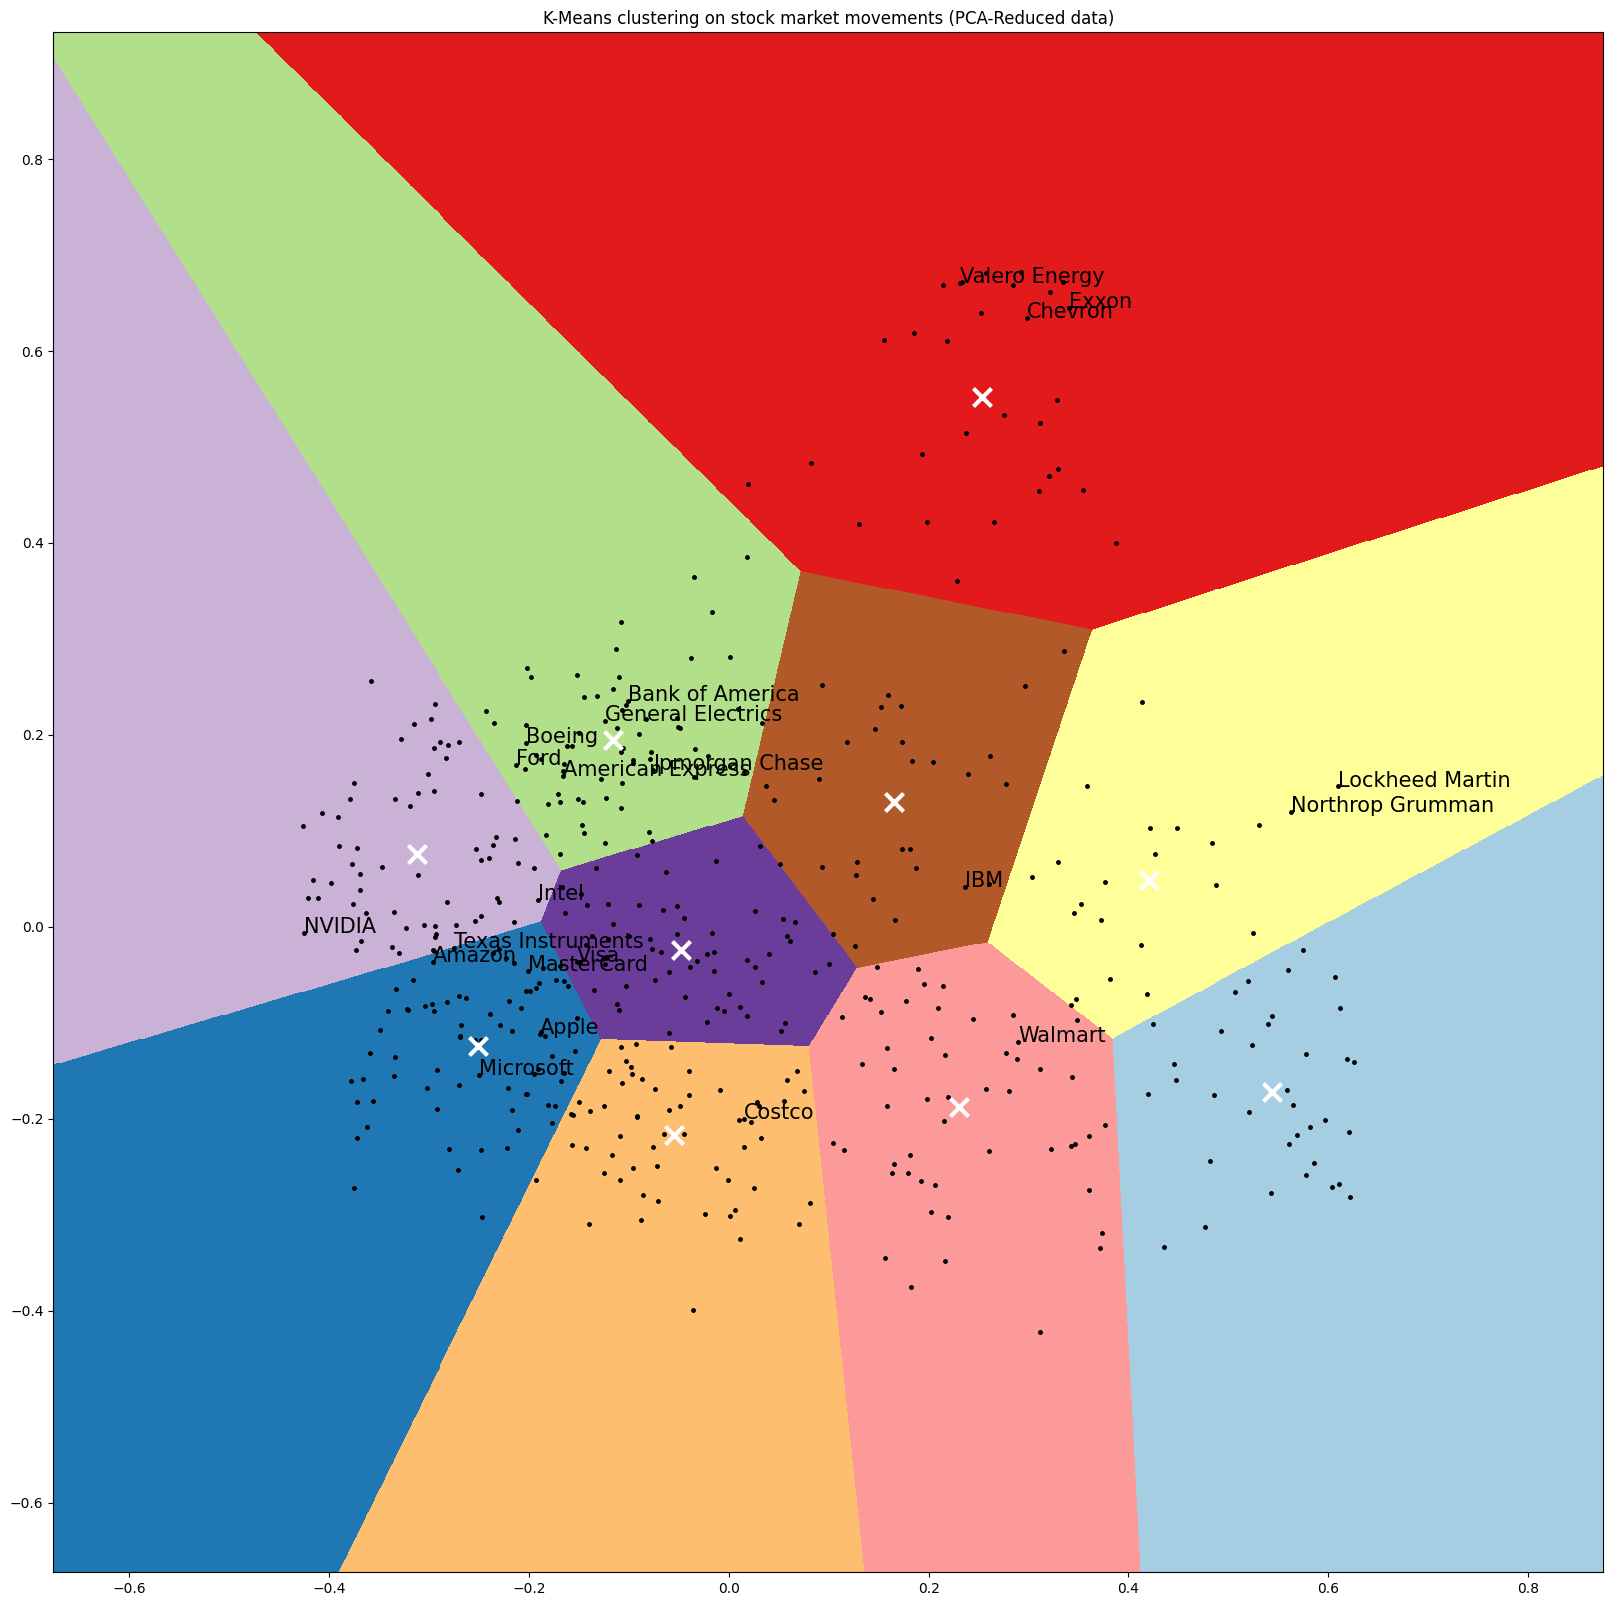

In [14]:
from sklearn.decomposition import PCA
# Reduce the data
reduced_data = PCA(n_components = 2).fit_transform(norm_returns)

# Define the buffer size for the plot
boundary_buffer_size = 0.25

# Define step size of mesh
h = 0.001
# Plot the decision boundary
x_min,x_max = reduced_data[:,0].min()-boundary_buffer_size, reduced_data[:,0].max() + boundary_buffer_size
y_min,y_max = reduced_data[:,1].min()-boundary_buffer_size, reduced_data[:,1].max() + boundary_buffer_size
xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))

# Obtain labels for each point in the mesh using our trained model
Z = kmeans.predict(np.c_[xx.ravel(),yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
# Define color plot
cmap = plt.cm.Paired

# Plotting figure
plt.clf()
plt.figure(figsize=(20,20))
plt.imshow(Z,interpolation = 'nearest',extent=(xx.min(),xx.max(),yy.min(),yy.max()),cmap = cmap,aspect = 'auto',origin = 'lower')
plt.plot(reduced_data[:,0],reduced_data[:,1],'k.',markersize = 5)
# Plot the centroid of each cluster as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0],centroids[:,1],marker = 'x',s = 169,linewidths = 3,color = 'w',zorder = 10)
plt.title('K-Means clustering on stock market movements (PCA-Reduced data)')
for name_, _ticker in companies_dict.items():
    if _ticker  in return_stocks.index.to_list():
      i = return_stocks.index.to_list().index(_ticker)
      plt.annotate(name_, (reduced_data[i,0], reduced_data[i,1]), fontsize=15)

plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.show()

# K-means Clustering with Dynamic Time Warping (DTW) on Stock Return

##Dynamic Time Warping

Dynamic Time Warping (DTW) is a method for measuring similarity between two temporal sequences that may vary in speed. It aligns time-series data by considering dynamic lead-lag or lag-lead relationships. The algorithm not only provides the best matching but also defines a distance metric specific to time-series shifting.

This metric can be applied to the stock market to offer insightful information. In the stock market, lead-lag and lag-lead effects are often present but cannot be captured by traditional covariance or correlation matrices. A distance matrix or similarity matrix constructed based on DTW can address this issue. Algorithms such as clustering, k-nearest neighbors classification, or PCA based on DTW-based matrices can generate perspectives that incorporate temporal information.

For more detail of [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping).

In [15]:
from tslearn.clustering import TimeSeriesKMeans

model = TimeSeriesKMeans(n_init = 10, n_clusters = n_clusters, metric = "dtw")
model.fit(return_stocks)
labels = model.predict(return_stocks)

stock_clusters_dtw = defaultdict(list)
for index in range(len(labels)):
    stock_clusters_dtw[labels[index]].append(return_stocks.index[index])

print(stock_clusters_dtw)
print(model.inertia_)

defaultdict(<class 'list'>, {5: ['A', 'ABT', 'ACGL', 'ACN', 'ADM', 'ADP', 'AES', 'AFL', 'AIG', 'AJG', 'AKAM', 'ALLE', 'AMCR', 'AME', 'AMT', 'AON', 'AOS', 'APD', 'APH', 'ARE', 'AVB', 'AVY', 'BG', 'BK', 'BLK', 'BR', 'BSX', 'BXP', 'C', 'CARR', 'CAT', 'CBRE', 'CCI', 'CDW', 'CMI', 'CNC', 'COO', 'COST', 'CPAY', 'CPT', 'CSCO', 'CSX', 'CTAS', 'CTVA', 'DD', 'DE', 'DG', 'DHR', 'DLR', 'DLTR', 'DOC', 'DOV', 'DOW', 'DPZ', 'DRI', 'ECL', 'EG', 'EMN', 'EMR', 'EQR', 'ESS', 'ETN', 'EXPD', 'FAST', 'FDS', 'FFIV', 'FI', 'FMC', 'FRT', 'FTV', 'GE', 'GL', 'GLW', 'GPC', 'GRMN', 'GS', 'GWW', 'HAS', 'HCA', 'HIG', 'HOLX', 'HON', 'HPE', 'HUBB', 'HUM', 'HWM', 'ICE', 'IEX', 'IFF', 'IP', 'IPG', 'IQV', 'IR', 'IT', 'ITW', 'J', 'JBHT', 'JCI', 'JNPR', 'JPM', 'KEYS', 'KIM', 'KMI', 'LH', 'LIN', 'LKQ', 'LYB', 'MA', 'MAA', 'MET', 'MKTX', 'MLM', 'MMC', 'MMM', 'MNST', 'MS', 'MSI', 'MTD', 'NDAQ', 'NDSN', 'NEE', 'NEM', 'NSC', 'NTAP', 'NTRS', 'NWS', 'NWSA', 'OKE', 'OMC', 'ORCL', 'OTIS', 'PAYX', 'PCAR', 'PCG', 'PFG', 'PH', 'PKG', 

In [16]:
companies_clusters_dtw = defaultdict(list)

for k,v in companies_dict.items():
    for j in stock_clusters_dtw:
        if v in stock_clusters_dtw[j]:
            companies_clusters_dtw[j].append(k)

companies_clusters_dtw

defaultdict(list,
            {1: ['Amazon', 'Apple', 'Intel', 'Microsoft'],
             0: ['American Express', 'Boeing', 'Bank of America', 'Ford'],
             9: ['Chevron', 'Exxon', 'Valero Energy'],
             5: ['Costco',
              'General Electrics',
              'Jpmorgan Chase',
              'MasterCard',
              'Texas Instruments',
              'Visa'],
             2: ['IBM', 'Lockheed Martin', 'Northrop Grumman', 'Walmart'],
             3: ['NVIDIA']})

In [17]:
ticker_to_pca_cordinates = {ticker_:reduced_data[index_] for index_, ticker_ in enumerate(return_stocks.index)}

<Figure size 2000x2000 with 0 Axes>

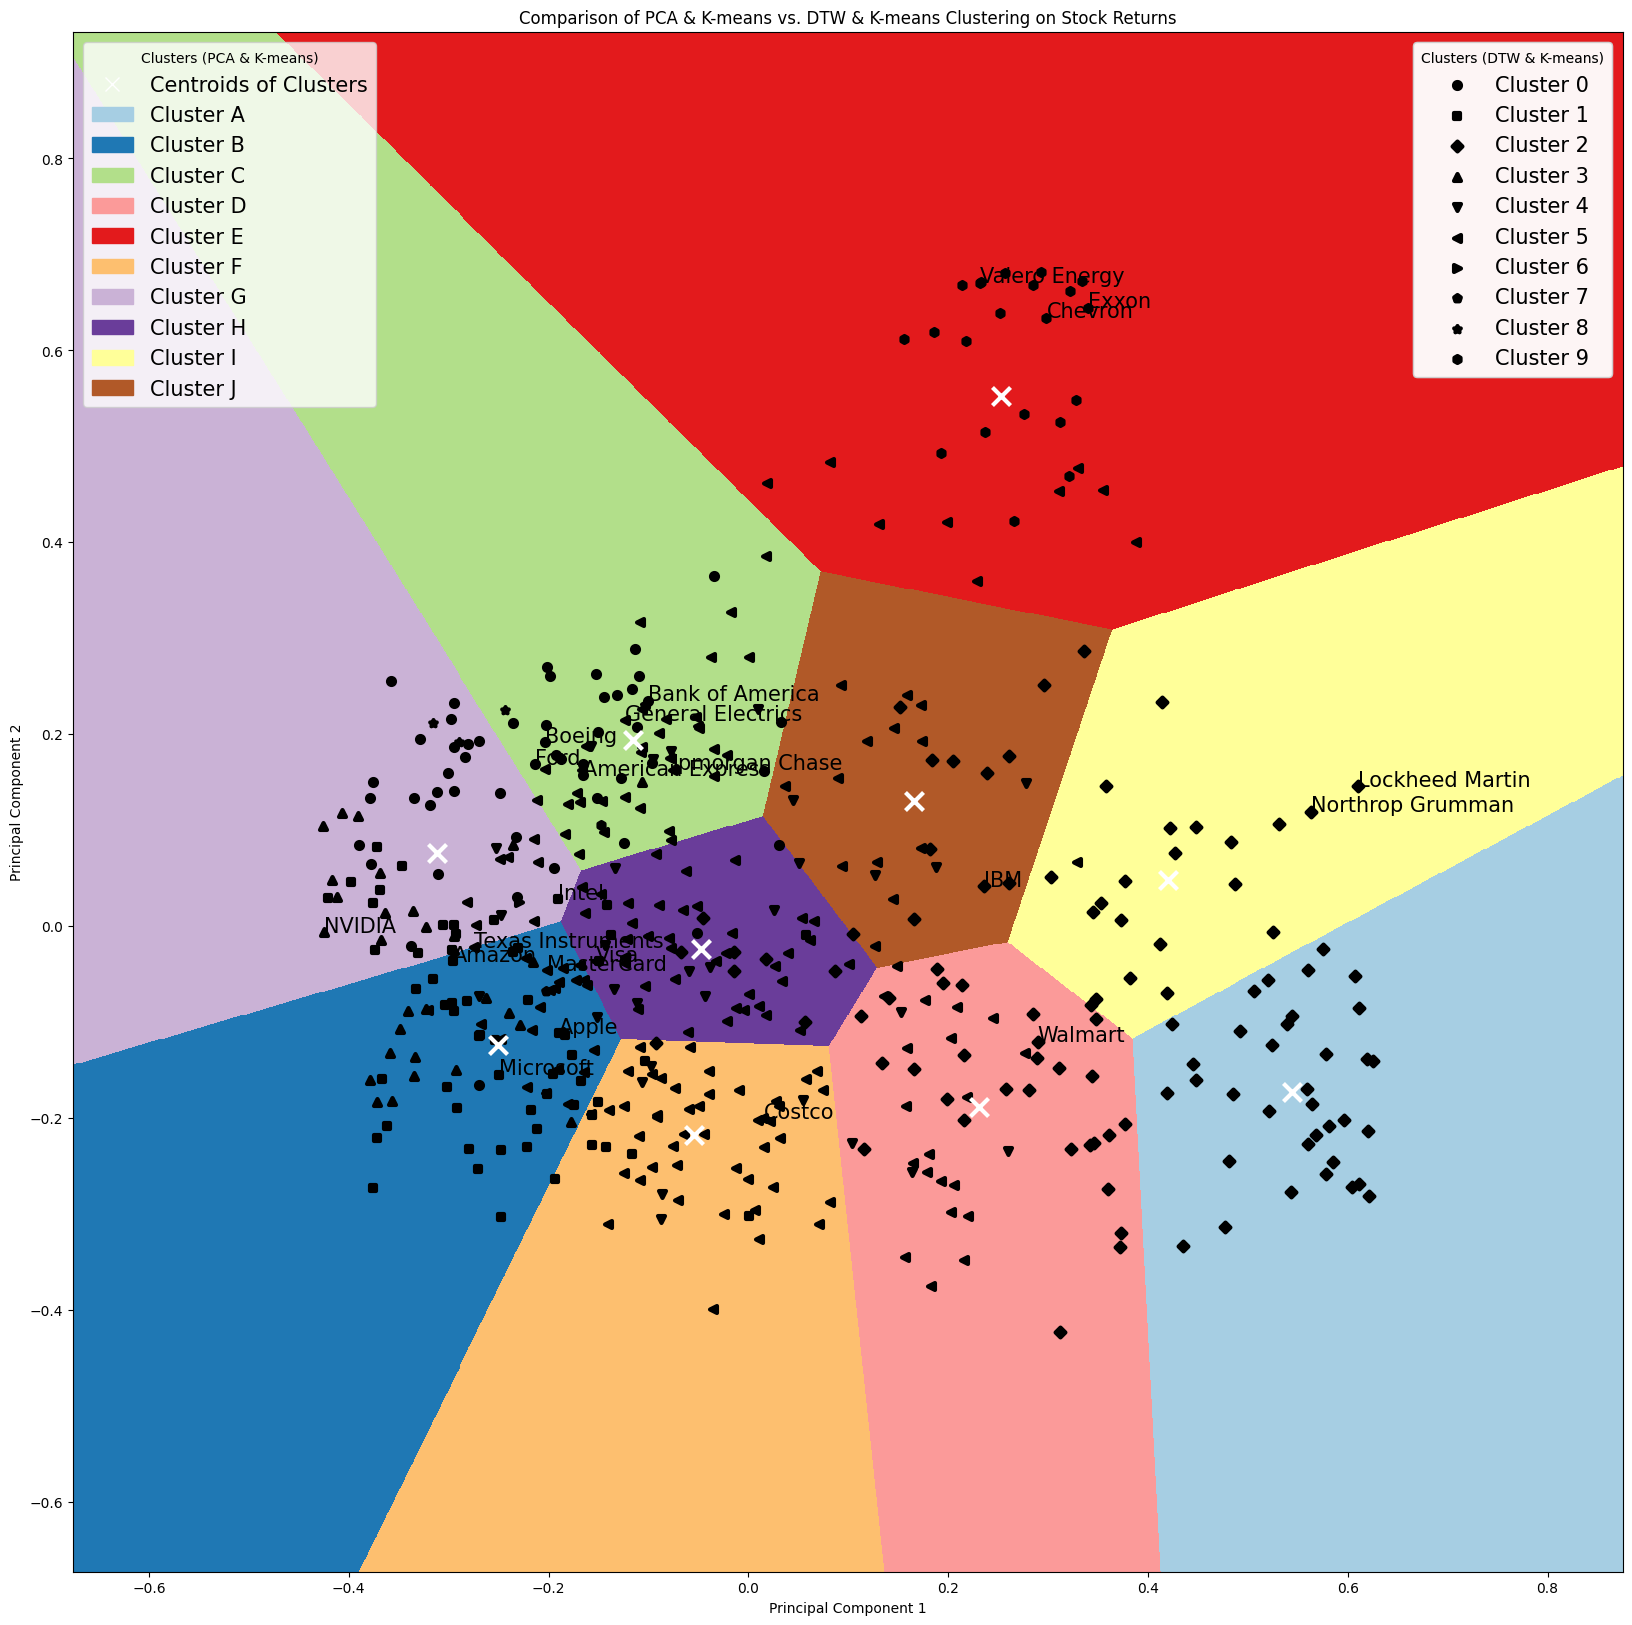

In [18]:
#Note: This plotting script is for demonstration purposes and is not intended for plotting more than 26 clusters.
#Note: The PC1 and PC2 is generate from applying PCA to normalized stock returns

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import string

# Plotting figure: deciding the figure size
fig, ax = plt.subplots(figsize=(20, 20))



#********************** Plot for PCA & K-means Clustering ********************** #

# Define the buffer size for the plot
boundary_buffer_size = 0.25

# Define step size of mesh
h = 0.001

# Plot the decision boundary of PCA & K-means clustering
x_min, x_max = reduced_data[:, 0].min() - boundary_buffer_size, reduced_data[:, 0].max() + boundary_buffer_size
y_min, y_max = reduced_data[:, 1].min() - boundary_buffer_size, reduced_data[:, 1].max() + boundary_buffer_size
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


# Obtain labels for each point in the mesh using our trained model
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
# Define color plot
cmap = plt.cm.Paired

# Plotting figure
plt.clf()
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=cmap, aspect='auto', origin='lower')

# Plot the centroid of each cluster as a white X
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)

# Create a color legend for the imshow plot
letters = list(string.ascii_uppercase)  # List of letters A, B, C, D, ...
unique_clusters = np.unique(Z)
z_min, z_max = unique_clusters.min(), unique_clusters.max()
normalized_colors = (unique_clusters - z_min) / (z_max - z_min)
color_legend_patches = [Patch(color=cmap(norm), label=f'Cluster {letters[cluster]}') for cluster, norm in zip(unique_clusters, normalized_colors)]
# Add the centroid's white X to the first element of legend
color_legend_patches.insert(0, Line2D([0], [0], marker='x', color='w', label='Centroids of Clusters', markersize=10, linewidth=0))
# Add the legend to the plot
color_legend = ax.legend(handles=color_legend_patches, loc='upper left', fontsize=15, title="Clusters (PCA & K-means)")
ax.add_artist(color_legend)


#********************** Plot for DTW & K-means Clustering ********************** #

# Define different shapes for different clusters of DTW & K-means clustering
markers = [
    'o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h',
    'H', '+', 'x', 'd', '|', '_', '1', '2', '3', '4',
    '8', 'P', 'X', 'd', 'H', '+', 'x', 'd', '|', '_'
]

# Keep track of handles and labels for the legend for DTW-based K-means Clusters
handles = []
labels = []

# Iterate over each DTW-based K-means clusters and plot the stocks
for cluster, companies in stock_clusters_dtw.items():
    marker = markers[int(cluster) % len(markers)]

    for company in companies:
        cluster_data = ticker_to_pca_cordinates[company]
        scatter = ax.scatter(cluster_data[0], cluster_data[1], marker=marker, s=25, linewidths=3, color='black', zorder=1)

    # Add a handle and label for the current cluster to the legend
    handles.append(scatter)
    labels.append(f'Cluster {cluster}')

# Sort handles and labels for DTW-based K-means Clusters
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Create the legend for DTW-based K-means Clusters
scatter_legend = ax.legend(sorted_handles, sorted_labels, loc='upper right', fontsize=15, title="Clusters (DTW & K-means)")
ax.add_artist(scatter_legend)


#********************** Mark Specific Companies ********************** #
# Mark company concerned on the plot
for name_, _ticker in companies_dict.items():
    if _ticker  in return_stocks.index.to_list():
      i = return_stocks.index.to_list().index(_ticker)
      plt.annotate(name_, (reduced_data[i,0], reduced_data[i,1]), fontsize=15)


#********************** Show the Graph! ********************** #
# Set plot limits
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Naming the plot
ax.set_title('Comparison of PCA & K-means vs. DTW & K-means Clustering on Stock Returns')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

plt.show()




In the graph above, I compare the clustering results of two methods: **PCA + K-means** and **DTW + K-means**.

#### Clustering Methods
- **PCA + K-means**: First, I obtain PC1 and PC2 from the normalized stock returns using PCA. Then, I apply K-means clustering based on PC1 and PC2. The clusters are represented by different colors as shown in the legend ("Clusters (PCA + K-means)"). The centroids of each cluster are marked with white crosses.
- **DTW + K-means**: I utilize Dynamic Time Warping (DTW) as the distance metric for the stock returns and then apply K-means clustering. The clusters are represented by different markers for data points as illustrated in the legend ("Clusters (DTW + K-means)").

The axes PC1 and PC2 of the plot are derived from PCA on normalized stock returns. (Note that for each clusters name A, B, C, D... or 1,2,3,4.... contain no ordinal informaiton.)

#### Observations

- **Similarity between Methods**: There is a noticeable degree of similarity between the two methods, as DTW can capture information that PCA also reveals.
  
  - **Cluster 2 (diamond marker)**: Predicted by DTW + K-means, mostly located at the bottom right of the graph, corresponds to Clusters I and A (light yellow and light blue) in PCA + K-means.
  
  - **Cluster 0 (ball marker)**: Mostly located at the top left of the graph, corresponds to Clusters C and G (light green and light purple) in PCA + K-means.

#### Economic Sectors Analysis

1. **Energy Sector (Valero Energy, Chevron, Exxon)**
   - **PCA + K-means**: These stocks are mapped to a similar region at the top of the graph (Cluster E, red area).
   - **DTW + K-means**: They are grouped into Cluster 9 (hexagon marker), indicating strong similarity in stock movement.

2. **Aerospace and Defense (Boeing, Lockheed Martin, Northrop Grumman)**
   - **PCA + K-means**: Lockheed Martin and Northrop Grumman are in Cluster I (light yellow).
   - **DTW + K-means**: Both are in Cluster 2 (diamond marker).
   - Boeing, however, is not classified into the same group by either method, indicating different influencing factors.

3. **Financial Services (American Express, Bank of America, JPMorgan Chase, MasterCard, Visa)**
   - **PCA + K-means**: Banks are close to each other (light green area), while Visa and MasterCard are nearby but in different groups.
   - **DTW + K-means**: Bank of America and American Express are in Cluster 0 (circle marker), whereas JPMorgan Chase, MasterCard, and Visa are in Cluster 5 (left-pointing triangle).

4. **Tech Stocks (Amazon, Apple, Intel, Microsoft, Texas Instruments, NVIDIA)**
   - **PCA + K-means**: Amazon, Apple, MasterCard, Microsoft, and Texas Instruments are in the same group (dark blue), with Intel and NVIDIA grouped together (light purple).
   - **DTW + K-means**: Amazon, Apple, Intel, and Microsoft are clustered together, showing that DTW captures temporal shifting/lead-lag effects.

#### Conclusion

Both PCA + K-means and DTW + K-means capture valuable information about stock movements. However, DTW + K-means also captures temporal relationships, making it a complementary method for comprehensive analysis. Utilizing both methods can provide a more nuanced understanding of stock dynamics. By delving into each group identified by DTW + K-means, I can discover the underlying forces, factors, economic shocks, and lead-lag effects that influence stock movements. This comprehensive analysis demonstrates the efficacy of combining multiple clustering techniques to reveal different aspects of stock return behavior.
